<a href="https://colab.research.google.com/github/brendanhasz/tfp-bayesian-regression/blob/master/TFP_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Regressions via MCMC or Variational Methods using TensorFlow Probability

One way to fit Bayesian models is using Markov chain Monte Carlo (MCMC) sampling. These methods generate samples from the posterior distribution such that the number of samples generated in a region of parameter-space is proportional to the posterior probability of those parameter values.  (Check out this [great animation](https://chi-feng.github.io/mcmc-demo/app.html#HamiltonianMC,banana) by Chi Feng to see how different MCMC algorithms sample the posterior distribution.) Programs and packages like [Stan](http://mc-stan.org/), [JAGS](http://mcmc-jags.sourceforge.net/), [BUGS](http://www.openbugs.net/w/FrontPage), [Edward](http://edwardlib.org/), and [PyMC3](https://docs.pymc.io/) implement MCMC sampling from user-specified Bayesian models.

One downside of these packages (with the exception of Edward) is that they don't support parallel or distributed sampling.  You can run independent sampling chains in parallel, of course, but any single chain with any of these environments is single-threaded.  This becomes a problem when you've got lots of data, because your models take forever to fit!  With many models, the computation of the posterior probability (and its gradient) can be distributed, and so computing these in a distributed way would significantly speed up sampling.

Most MCMC methods, like [Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) (HMC), and the [No-U-Turn sampler](http://www.jmlr.org/papers/v15/hoffman14a.html) (NUTS), use the gradient of the posterior probability to traverse parameter-space in order to efficiently sample the posterior.  Stan (and other packages) use [reverse-mode automatic differentiation](https://rufflewind.com/2016-12-30/reverse-mode-automatic-differentiation) to compute the gradient (also see [this post](https://rufflewind.com/2016-12-30/reverse-mode-automatic-differentiation)).  Basically this allows the user to build a program to compute the posterior probability from a model and data, and the gradient of the posterior is computed from this program automatically using the derivatives of simple components of that program and the chain rule.

It occurred to me that this is exaclty what [TensorFlow](https://www.tensorflow.org/) does!  Edward (which runs on top of TensorFlow) implements a few types of MCMC samplers, but not the NUTS sampler.  While googling for a TensorFlow-based NUTS sampler, I stumbled across [TensorFlow Probability](https://www.tensorflow.org/probability/), which is a new offshoot of TensorFlow, dedicated to fitting probabilistic modeling.  And they're working on a NUTS sampler for it!

In this post we'll use TensorFlow Probability to build and fit Bayesian Regression models, first with MCMC and then using stochastic variational inference.

>[Bayesian Regressions via MCMC or Variational Methods using TensorFlow Probability](#scrollTo=nwfwD2lsgp64)

>>[Data](#scrollTo=5Sl3oQAlVVYQ)

>>[Markov Chain Monte Carlo](#scrollTo=VeuCuk2zgPTx)

>>>[Bayesian Model](#scrollTo=9cCxquAOP-Sp)

>>>[MCMC Sampling](#scrollTo=4T_pXKJbVPs1)

>>>[Posterior](#scrollTo=3LjFseDRiyfl)

>>>[Posterior Predictive Distribution](#scrollTo=vXRshfpUd_nc)

>>>[Prediction Distributions](#scrollTo=wVzQW2szmGUj)

>>[Variational Bayes](#scrollTo=AVYSmZ6exIlh)

>>>[Data Pipeline](#scrollTo=HUlFbmPpzboP)

>>>[Variational Model](#scrollTo=p1rmKI6ozuK0)

>>>[Fitting the Variational Model](#scrollTo=Pd_WGG-ziII4)

>>>[Parameters and metrics over training](#scrollTo=EVct2VF8X9d3)

>>>[Posterior](#scrollTo=LbDLJkLAtGCY)

>>>[Prediction Distributions](#scrollTo=e9ljOhywieDm)

>>[Comparing MCMC and Variational Fits](#scrollTo=q0VU7eLaagiu)

>>>[Posteriors](#scrollTo=E-aZrH4ni1TK)

>>>[Prediction Distributions](#scrollTo=TL8RbElNitoo)

>>[Conclusion](#scrollTo=2_LECAWfpeTm)



First let's load the packages we need.  

In [0]:
!pip install -q tfp-nightly

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import norm

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%config InlineBackend.figure_format = 'svg'
np.random.seed(12345)
tf.set_random_seed(12345)

## Data

We need some data to fit our Bayesian models to!  Let's use a simple linear model to generate some data:

\begin{align*}
y_i &\sim \text{Normal}(\alpha + x_i^\top \beta, ~ \sigma^2)
\end{align*}

where 

* $y_i$ is the observed value for datapoint $i$,
* $\alpha$ is a bias parameter (the intercept),
* $x_i$ is the vector of features (independent variables) for datapoint $i$,
* $\beta$ is a vector of coefficients (weights), and
* $\sigma$ is the error standard deviation.

So, the $y$ value of each datapoint is set by the intercept, plus the effect of the dependent variables according to the weights, plus some noise.

In [0]:
# Settings
D = 4   #number of dimensions
N = 100 #number of datapoints to generate
noise_std_true = 1.0

# Generate data
b_true = np.random.randn(1).astype(np.float32)    #bias (alpha)
w_true = np.random.randn(D, 1).astype(np.float32) #weights (beta)
x = np.random.randn(N, D).astype(np.float32)
noise = noise_std_true * np.random.randn(N,1).astype(np.float32)
y = np.matmul(x, w_true) + b_true + noise

Let's view the datapoints we generated.

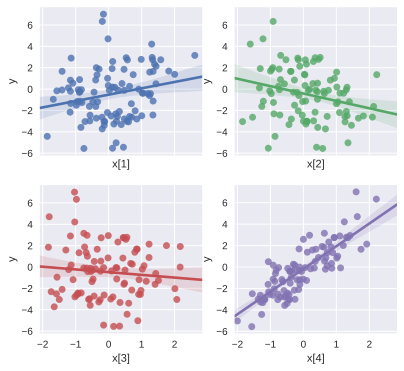

In [4]:
# Show data
fig, axes = plt.subplots(int(np.ceil(D/2)), 2, sharex=True)
fig.set_size_inches(6.4, 6)
for i in range(D):
  t_ax = axes[int(i/2), i%2] #this axis
  sns.regplot(x[:,i], y[:,0], ax=t_ax)
  t_ax.set_ylabel('y')
  t_ax.set_xlabel('x[%d]'%(i+1))
plt.show()

The bias looks to be around $2$, and some weights look likely positive (like $\beta_2$), while other weights look likely to be negative (like $\beta_3$ and $\beta_4$).  Let's take a look at the parameters which were used to generate the data.

In [5]:
print('True bias: %0.2f' % b_true)
print('True weights: ', w_true[:,0])

True bias: -0.20
True weights:  [ 0.47894335 -0.51943874 -0.5557303   1.9657806 ]


## Markov Chain Monte Carlo

The first method for fiting Bayesian models we'll look at is Markov chain Monte Carlo (MCMC) sampling.  Again, MCMC methods traverse parameter-space, generating samples from the posterior distribution such that the number of samples generated in a region of parameter-space is proportional to the posterior probability in that region of parameter-space.

### Bayesian Model

The model we'll use is a simple Bayesian linear regression.  That is, the same model we used to generate the data:

\begin{align*}
y_i &\sim \text{Normal}(\alpha + x_i^\top \beta, ~ \sigma^2)
\end{align*}

However, we'll also put priors on the parameters:

\begin{align*}
\beta &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{HalfNormal}(1) \\
\alpha &\sim \text{Normal}(0, 1) \\
\end{align*}

We'll use the `edward` module from TensorFlow Probability to code the model:

In [0]:
def linear_regression(features):
  D = features.shape[1]      #number of dimensions
  coeffs = ed.Normal(        #normal prior on weights
      loc=tf.zeros([D,1]),
      scale=tf.ones([D,1]),
      name="coeffs")
  bias = ed.Normal(          #normal prior on bias
      loc=tf.zeros([1]), 
      scale=tf.ones([1]),
      name="bias") 
  noise_std = ed.HalfNormal( #half-normal prior on noise std
      scale=tf.ones([1]),
      name="noise_std")
  predictions = ed.Normal(   #normally-distributed noise around predicted values
      loc=tf.matmul(features, coeffs)+bias,
      scale=noise_std,
      name="predictions")
  return predictions

We want to perform MCMC within the joint probability distribution of all the parameters, so we'll have to convert our function above into a joint distribution function (`edward` provides a function to do that).  

In [0]:
# Joint posterior distribution
log_joint = ed.make_log_joint_fn(linear_regression)

We'll also need a function to compute the log posterior probability

In [0]:
# Function to compute the log posterior probability
def target_log_prob_fn(coeffs, bias, noise_std):
  return log_joint(
      features=x,
      coeffs=coeffs,
      bias=bias,
      noise_std=noise_std,
      predictions=y)

### MCMC Sampling

Now that we've built the model, we can use MCMC sampling to estimate the posterior distribution.  

First though, let's make a timer,

In [0]:
class Timer:
  def __enter__(self):
    self.t0 = time.time()
  def __exit__(self, *args):
    print('Elapsed time: %0.2fs' % (time.time()-self.t0))

so that now we can time blocks of code inside `with Timer()`:

In [10]:
with Timer():
  time.sleep(3.14)

Elapsed time: 3.14s


Before sampling, we need to set how many sampling iterations we want to perform, and the number of burn-in steps (we toss samples up to the number of burn-in steps).  We also need to set the HMC step size and the number of leapfrog steps (the number of steps to take after an initial momentum is applied before a "sample" is taken).

In [0]:
# HMC Settings
num_results = int(10e3) #number of hmc iterations
n_burnin = int(5e3)     #number of burn-in steps
step_size = 0.01
num_leapfrog_steps = 10

# Parameter sizes
coeffs_size = [D,1]
bias_size = [1]
noise_std_size = [1]

Then, we can define the transition kernel we'll use (Hamiltonian Monte Carlo, though TFP offers a [bunch](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc) of different sampling algorithms, including an [experimental NUTS sampler](https://github.com/tensorflow/probability/tree/master/experimental/no_u_turn_sampler)).  We'll also create a TensorFlow graph to generate the entire chain of samples. 

In [0]:
# HMC transition kernel
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=step_size,
    num_leapfrog_steps=num_leapfrog_steps)

# Define the chain states
states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=n_burnin,
    kernel=kernel,
    current_state=[
        tf.zeros(coeffs_size, name='init_coeffs'),
        tf.zeros(bias_size, name='init_bias'),
        tf.ones(noise_std_size, name='init_noise_std'),
    ])
coeffs, bias, noise_std = states

Finally, we can run the MCMC sampling chain, and afterwards remove samples during the burn-in period.

In [13]:
# Run the chain
with Timer(), tf.Session() as sess:
  [
      coeffs_,
      bias_,
      noise_std_,
      is_accepted_,
  ] = sess.run([
      coeffs,
      bias,
      noise_std,
      kernel_results.is_accepted,
  ])

# Samples after burn-in
coeffs_samples = coeffs_[n_burnin:,:,0]
bias_samples = bias_[n_burnin:]
noise_std_samples = noise_std_[n_burnin:]
accepted_samples = is_accepted_[n_burnin:]

Elapsed time: 20.58s


One thing we have to check for is that not *all* our sampling iterations have been rejected (that is, that many are accepted).  Hamiltonian Monte Carlo only accepts a sample when the posterior probability at the proposed sample location is favorable compared to the probability at the previous location.  If none of our samples are being accepted, it could mean that the step size is too large, or larger problems with the model.

In [14]:
print('Acceptance rate: %0.1f%%' % (100*np.mean(accepted_samples)))

Acceptance rate: 99.7%


There's quite a few other MCMC diagnostics which one would usually want to check for, including chain convergence, energy Bayesian fraction of missing information (E-BFMI), divergences, etc, which I talked about in a [previous post](https://brendanhasz.github.io/2018/10/10/hmm-vs-gp.html).  Unfortunately, TFP doesn't yet provide functions to check these.  Though, checking for chain convergence could be done manually pretty easily.

### Posterior

Next, we'll take a look at the posterior distributions for the parameters of our model.  In each of the plots below, the solid vertical line is the true value of the parameter, the distribution is the posterior as estimated by MCMC sampling, and the dotted lines indicate the 95% confidence interval of the posterior distribution.

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

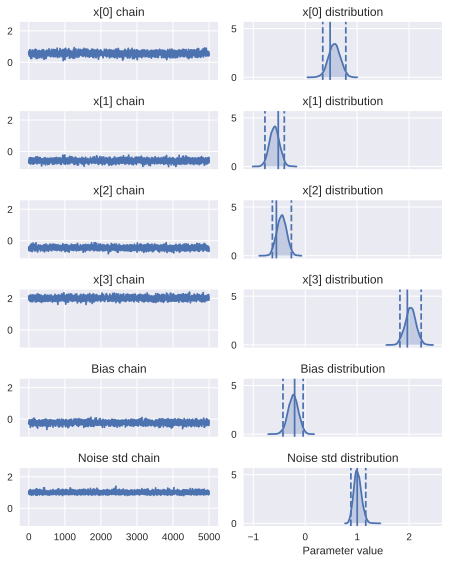

In [15]:
def chain_plot(data, title='', ax=None):
  '''Plot both chain and posterior distribution'''
  if ax is None:
    ax = plt.gca()
  ax.plot(data)
  ax.title.set_text(title+" chain")
  
def post_plot(data, title='', ax=None, true=None, prc=95):
  '''Plot the posterior distribution given MCMC samples'''
  if ax is None:
    ax = plt.gca()
  sns.kdeplot(data, ax=ax, shade=True)
  ax.axvline(x=np.percentile(data, (100-prc)/2), linestyle='--')
  ax.axvline(x=np.percentile(data, 100-(100-prc)/2), linestyle='--')
  ax.title.set_text(title+" distribution")
  if true is not None:
    ax.axvline(x=true)
    
def chain_post_plot(data, title='', ax=None, true=None):
  '''Plot a chain of MCMC samples'''
  chain_plot(data, title=title, ax=ax[0])
  post_plot(data, title=title, ax=ax[1], true=true)
  
# Plot chains and distributions for coefficients
fig, axes = plt.subplots(D+2, 2, sharex='col', sharey='col')
fig.set_size_inches(6.4, 8)
for i in range(D):
  chain_post_plot(coeffs_samples[:,i],
                  title="x[{}]".format(i),
                  ax=axes[i], true=w_true[i])
  
# Plot chains and distributions for bias
chain_post_plot(bias_samples[:,0],
                title="Bias",
                ax=axes[D], true=b_true)

# Plot chains and distributions for noise std dev
chain_post_plot(noise_std_samples[:,0],
                title="Noise std",
                ax=axes[D+1], true=noise_std_true)
  
axes[D+1][1].set_xlabel("Parameter value")
fig.tight_layout()
plt.show()

It looks like our model accurately recovered the true parameters used to generate the data!

### Predictive Distribution

To "criticize" our model, we can take a look at the posterior predictive distributions on held-out (validation) data.  The posterior predictive distribution is the distribution of $y$ values which our model predicts for a given held-out $x$, if we assume that the true parameter values follow the probability distribution that we computed using the non-held-out data (the posterior).  That is, it's how likely any given $y$ value is for a new $x$ value, if we incorporate all our sources of uncertainty.

To look at the posterior predictive distributions, we need held-out data, so we'll first generate some validation data:

In [0]:
# Generate held out data
N_val = 1000
x_val = np.random.randn(N_val, D).astype(np.float32)
noise = noise_std_true * np.random.randn(N_val, 1).astype(np.float32)
y_val = np.matmul(x_val, w_true) + b_true + noise

Then we can compute the predictive distributions.  We'll draw one sample from our probabilistic model per MCMC sample from the posterior distribution (though we could do more).

TensorFlow Probability (and Edward) provide a method to do this they call "intercepting", which allows the user to set the value of the model parameters, and then draw a sample from the model.  Unfortunately this method isn't well-suited to drawing many samples each with different parameter values (i.e. it takes a long time), so we'll just do it manually.

In the figure below, each plot corresponds to a different validation datapoint (I've only plotted 8 out of the 1000 we generated), the vertical lines show the true value of $y$ for that datapoint, and the distributions show the predictive distristribution (our guess for how likely each value of $y$ is given our model and our uncertainty as to the model's parameters).

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

Text(0.5,0,'y')

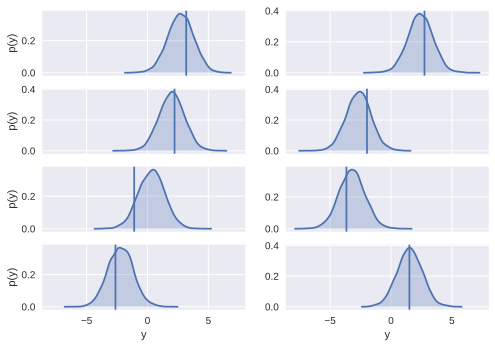

In [29]:
def ind_prediction_distribution(X):
  '''Compute the prediction distribution for an individual validation example'''
  predictions = np.matmul(X, coeffs_samples.transpose()) + bias_samples[:,0]
  noise = noise_std_samples[:,0]*np.random.randn(noise_std_samples.shape[0])
  return predictions + noise

# Compute prediction distribution for all validation samples
Nmcmc = coeffs_samples.shape[0]
prediction_distribution = np.zeros((N_val, Nmcmc))
for i in range(N_val):
  prediction_distribution[i,:] = ind_prediction_distribution(x_val[i,:])

# Plot random datapoints and their prediction intervals
fig, axes = plt.subplots(4, 2, sharex='all')
for i in range(4):
  for j in range(2):
    ix = i*2+j
    pred_dist = prediction_distribution[ix,:]
    sns.kdeplot(pred_dist, shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix,0])
  axes[i][0].set_ylabel('p(y)')
  
axes[3][0].set_xlabel('y')
axes[3][1].set_xlabel('y')

We can also take the mean of each posterior predictive distribution, and compute the residuals (difference between the mean of each held-out datapoint's true $y$ value and the mean of that datapoint's posterior predictive distribution).

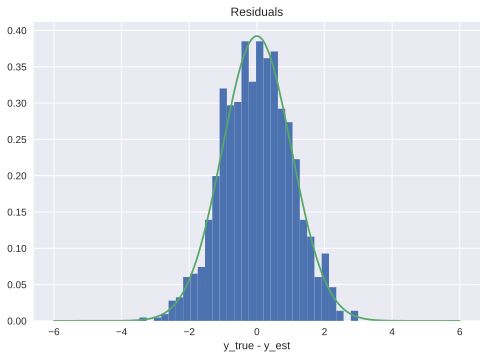

In [27]:
# Plot the residual distribution
plt.figure()
y_pred = np.mean(prediction_distribution, axis=1)
residuals = y_val[:,0]-y_pred
plt.hist(residuals, bins=30, density=True)
xx = np.linspace(-6, 6, 200)
plt.plot(xx, norm.pdf(xx, scale=np.std(residuals)))
plt.title('Residuals')
plt.xlabel('y_true - y_est')
plt.show()

We used a normal distribution to model the error, so the residuals should be normally-distributed.  The residuals look pretty good normally-distributed, but if they hadn't, we might have wanted to change the type of distribution used to model noise.

To asses how accurate our uncertainty estimates are, we can compute the coverage of the 95% interval.  That is, how often does the true $y$ value actually fall within the 95% interval of our posterior predictive distribution?  If our model is accurately capturing its uncertainty, then 95% of the true values should fall within the 95% interval of their posterior predictive distributions.

In [20]:
# Compute proportion of estimates on validation data 
# which fall within the 95% prediction interval
q0 = 2.5
q1 = 97.5
within_conf_int = np.zeros(N_val)
for i in range(N_val):
  pred_dist = prediction_distribution[i,:]
  p0 = np.percentile(pred_dist, q0)
  p1 = np.percentile(pred_dist, q1)
  if p0<=y_val[i] and p1>y_val[i]:
    within_conf_int[i] = 1

print('%0.1f %% of validation samples are w/i the %0.1f %% prediction interval' 
      % (100*np.mean(within_conf_int), q1-q0))

94.9 % of validation samples are w/i the 95.0 % prediction interval


The true coverage of the 95% interval is close to 95%, which means our model is pretty well-calibrated!

## Variational Bayes

cant do MCMC w/ full neural nets, would take too long, but can do variational! Talk about the upsides (fast) but also the downsides (assumes all params posteriors are independent)

We'll use a super-simple Bayesian neural network and ensure it comes up with the same uncertainty as the previous model which we fit with MCMC

First we'll set the batch size, number of training iterations, and the learning rate.

In [0]:
# Settings
batch_size = 50
max_steps = 2000
learning_rate = 0.01

### Data Pipeline

For the variational model, we first need to set up a data pipeline. 
TODO: explain

In [23]:
def build_input_pipeline(x, y, x_val, y_val, batch_size, N_val):
  '''Build an Iterator switching between train and heldout data.
  Args:
    x: Numpy `array` of training features, indexed by the first dimension.
    y: Numpy `array` of training labels, with the same first dimension as `x`.
    x_val: Numpy `array` of validation features, indexed by the first dimension.
    y_val: Numpy `array` of validation labels, with the same first dimension as `x_val`.
    batch_size: Number of elements in each training batch.
    N_val: Number of examples in the validation dataset
  Returns:
    batch_features: `Tensor` feed  features, of shape
      `[batch_size] + x.shape[1:]`.
    batch_labels: `Tensor` feed of labels, of shape
      `[batch_size] + y.shape[1:]`.
  '''
  # Build an iterator over training batches.
  training_dataset = tf.data.Dataset.from_tensor_slices((x, y))
  training_batches = training_dataset.shuffle(
      50000, reshuffle_each_iteration=True).repeat().batch(batch_size)
  train_iterator = training_batches.make_one_shot_iterator()

  # Build a iterator over the validation set with batch_size=N_val,
  # i.e., return the entire heldout set as a constant.
  val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  val_frozen = val_dataset.take(N_val).repeat().batch(N_val)
  val_iterator = val_frozen.make_one_shot_iterator()

  # Combine these into a feedable iterator that can switch between training
  # and validation inputs.
  handle = tf.placeholder(tf.string, shape=[])
  feedable_iterator = tf.data.Iterator.from_string_handle(
      handle, training_batches.output_types, training_batches.output_shapes)
  batch_features, batch_labels = feedable_iterator.get_next()

  return batch_features, batch_labels, handle, train_iterator, val_iterator

# DEBUGGER: reset the graph so you can re-run
tf.reset_default_graph() 

# Build input pipeline
x_vals, y_vals,  handle, training_iterator, validation_iterator = (
    build_input_pipeline(x, y, x_val, y_val, batch_size, N_val) )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


### Variational Model

TODO: net diagram

Now we can construct the variational model...

In [0]:
# A linear regression model: a Normal distribution
# parameterized by location from a single linear layer.
with tf.name_scope("linear_regression", values=[x_vals]):
  layer = tfp.layers.DenseFlipout(
      units=1, 
      activation=None,
      kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
      bias_posterior_fn=tfp.layers.default_mean_field_normal_fn())
  predictions = layer(x_vals)  
  noise_std = tf.get_variable("noise_std", initializer=tf.ones([1]))
  pred_distribution = tfd.Normal(loc=predictions, scale=noise_std)

### Fitting the Variational Model

TODO: explain below



In [25]:
# Compute the -ELBO as the loss, averaged over the batch size
neg_log_likelihood = -tf.reduce_mean(pred_distribution.log_prob(y_vals))
kl_div = sum(layer.losses) / N
elbo_loss = neg_log_likelihood + kl_div

# Mean squared error metric for evaluation
mse, mse_update_op = tf.metrics.mean_squared_error(
    labels=y_vals, predictions=predictions)

# Use ADAM optimizer w/ -ELBO loss
with tf.name_scope("train"):
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(elbo_loss)

# To store parameter values over training
weight_mean = layer.kernel_posterior.mean()[:,0]
weight_std = layer.kernel_posterior.stddev()[:,0]
bias_mean = layer.bias_posterior.mean()
bias_std = layer.bias_posterior.stddev()
weight_means = np.zeros((max_steps, D))
weight_stds = np.zeros((max_steps, D))
bias_means = np.zeros(max_steps)
bias_stds = np.zeros(max_steps)
noise_stds = np.zeros(max_steps)
mses = np.zeros(max_steps)
losses = np.zeros(max_steps)
pred_distribution_means = pred_distribution.mean()

# Initialization op
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

# Run the training session
with tf.Session() as sess:
  sess.run(init_op)

  # Training loop
  train_handle = sess.run(training_iterator.string_handle())
  val_handle = sess.run(validation_iterator.string_handle())
  with Timer():
    for iS in range(max_steps):
      [
          _,
          _,
          mses[iS],
          losses[iS],
          weight_means[iS,:],
          weight_stds[iS,:],
          bias_means[iS],
          bias_stds[iS],
          noise_stds[iS]
      ] = sess.run([
          train_op,
          mse_update_op,
          mse,
          elbo_loss,
          weight_mean,
          weight_std,
          bias_mean,
          bias_std,
          noise_std
      ], feed_dict={handle: train_handle})

  # Draw samples from the posterior
  Nmc = 1500
  w_draw = layer.kernel_posterior.sample(Nmc)
  b_draw = layer.bias_posterior.sample(Nmc)
  w_post, b_post = sess.run([w_draw, b_draw])
  
  # Draw prediction distribution samples
  prediction_dist_var = sess.run((pred_distribution.sample(Nmc)), 
                                 feed_dict={handle: val_handle})

Elapsed time: 2.45s


### Parameters and metrics over training

Let's visualize the posterior distributions which were computed using variational fit.

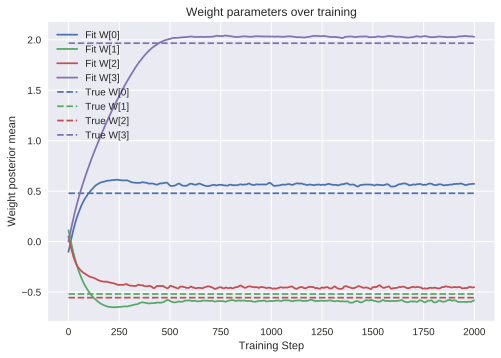

In [26]:
# Plot value of weights over training
plt.figure()
for iW in range(D):
  plt.plot(weight_means[:,iW], label='Fit W[{}]'.format(iW), 
           color=colors[iW])
  plt.hlines(w_true[iW], 0, max_steps, label='True W[{}]'.format(iW), 
             color=colors[iW], linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Weight posterior mean')
plt.title('Weight parameters over training')
plt.legend()
plt.show()

talk about why the values tend towards zero relative to their true values (priors!)

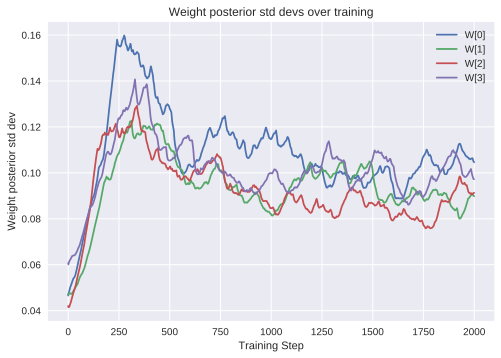

In [27]:
# Plot value of weight std devs over training
plt.figure()
for iW in range(D):
  plt.plot(weight_stds[:,iW], label='W[{}]'.format(iW), 
           color=colors[iW])
plt.xlabel('Training Step')
plt.ylabel('Weight posterior std dev')
plt.title('Weight posterior std devs over training')
plt.legend()
plt.show()

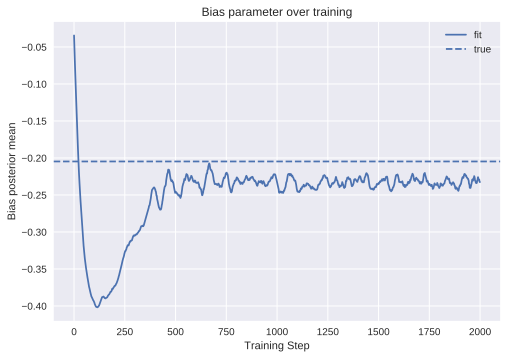

In [28]:
# Plot value of bias over training
plt.figure()
plt.plot(bias_means, label='fit')
plt.axhline(b_true, label='true', linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Bias posterior mean')
plt.title('Bias parameter over training')
plt.legend()
plt.show()

make sure the std dev doesn't shrink to 0 w/ more training?

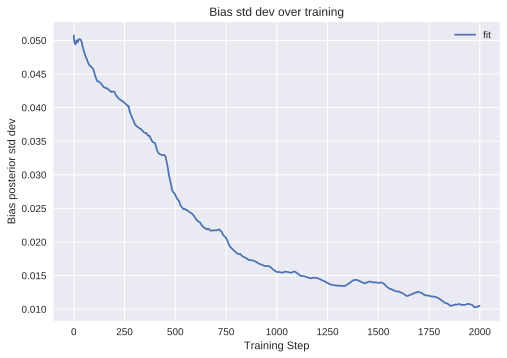

In [29]:
# Plot value of bias std dev over training
plt.figure()
plt.plot(bias_stds, label='fit')
plt.xlabel('Training Step')
plt.ylabel('Bias posterior std dev')
plt.title('Bias std dev over training')
plt.legend()
plt.show()

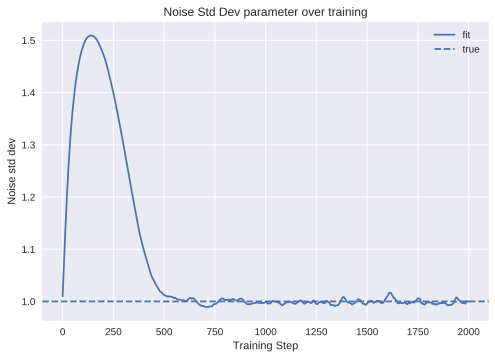

In [30]:
# Plot value of noise std dev over training
plt.figure()
plt.plot(noise_stds, label='fit')
plt.axhline(noise_std_true, label='true', linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Noise std dev')
plt.title('Noise Std Dev parameter over training')
plt.legend()
plt.show()

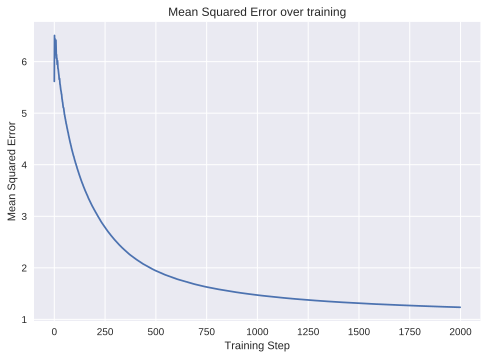

In [31]:
# Plot mean squared error over training
plt.figure()
plt.plot(mses[1:])
plt.xlabel('Training Step')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error over training')
plt.show()

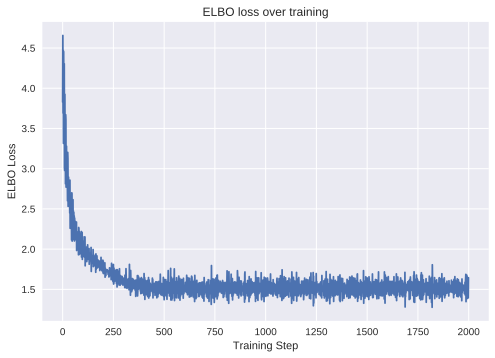

In [32]:
# Plot ELBO loss over training
plt.figure()
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('ELBO Loss')
plt.title('ELBO loss over training')
plt.show()

### Posterior

And we can also take a look at the posterior distributions for the weight and bias parameters (at the end of training).

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

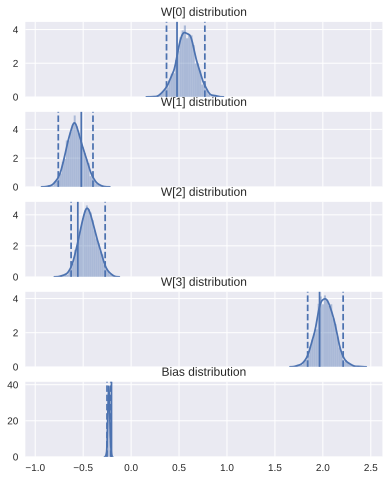

In [33]:
def post_plot(data, title='', ax=None, true=None, prc=95):
  if ax is None:
    ax = plt.gca()
  sns.distplot(data, ax=ax)
  ax.axvline(x=np.percentile(data, (100-prc)/2), linestyle='--')
  ax.axvline(x=np.percentile(data, 100-(100-prc)/2), linestyle='--')
  ax.title.set_text(title+" distribution")
  if true is not None:
    ax.axvline(x=true)

# Plot weight posteriors
fig, axes = plt.subplots(D+1, 1, sharex=True)
fig.set_size_inches(6.4, 8)
for i in range(D):
  post_plot(w_post[:,i,0], title='W[{}]'.format(i), 
            ax=axes[i], true=w_true[i])
  
# Plot Bias posterior
post_plot(b_post[:,0], title='Bias', 
          ax=axes[D], true=b_true)
plt.show()

### Prediction Distributions

TODO

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

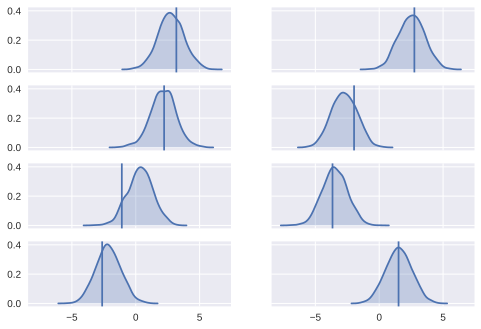

In [34]:
# Plot random datapoints and their prediction distributions
fig, axes = plt.subplots(4, 2, sharex='all', sharey='all')
for i in range(4):
  for j in range(2):
    ix = i*2+j
    pred_dist = prediction_dist_var[:, ix, 0]
    sns.kdeplot(pred_dist, shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix,0])

and can also look @ the coverage of the 95% conf interval for the variational model:

In [35]:
# Compute proportion of estimates on validation data 
# which fall within the 95% prediction interval
q0 = 2.5
q1 = 97.5
within_conf_int = np.zeros(N_val)
for i in range(N_val):
  pred_dist = prediction_dist_var[:, i, 0]
  p0 = np.percentile(pred_dist, q0)
  p1 = np.percentile(pred_dist, q1)
  if p0<=y_val[i] and p1>y_val[i]:
    within_conf_int[i] = 1

print('%0.1f %% of validation samples are w/i the %0.1f %% prediction interval' 
      % (100*np.mean(within_conf_int), q1-q0))

93.0 % of validation samples are w/i the 95.0 % prediction interval


## Comparing MCMC and Variational Fits

TODO

### Posteriors

TODO: comparing the posteriors...

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

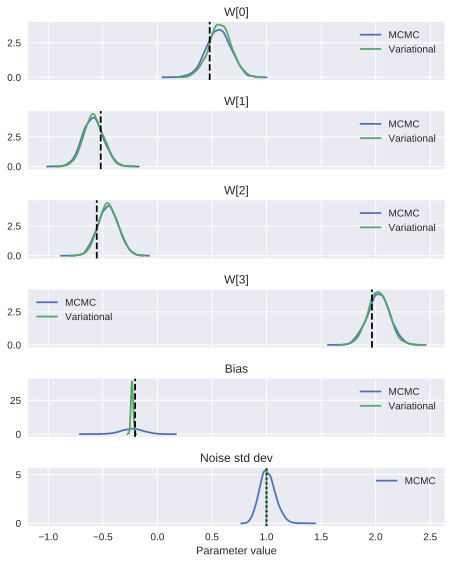

In [38]:
# Plot chains and distributions for coefficients
fig, axes = plt.subplots(D+2, 1, sharex='all')
fig.set_size_inches(6.4, 8)
for i in range(D):
  t_ax = axes[i]
  sns.kdeplot(coeffs_samples[:,i], #MCMC posterior
              ax=t_ax, label='MCMC') 
  sns.kdeplot(w_post[:,i,0], #variational posterior
              ax=t_ax, label='Variational') 
  t_ax.axvline(x=w_true[i], #true value
               color='k', linestyle=':') 
  t_ax.title.set_text('W[{}]'.format(i))
  
# Plot chains and distributions for bias
t_ax = axes[D]
sns.kdeplot(bias_samples[:,0], #MCMC posterior
            ax=t_ax, label='MCMC') 
sns.kdeplot(b_post[:,0], #variational posterior
            ax=t_ax, label='Variational') 
t_ax.axvline(x=b_true, #true value
             color='k', linestyle=':') 
t_ax.title.set_text('Bias')

# Plot chains and distributions for noise std dev
t_ax = axes[D+1]
sns.kdeplot(noise_std_samples[:,0], #MCMC posterior
            ax=t_ax, label='MCMC') 
t_ax.axvline(x=noise_stds[-1], #variational estimate
             color=colors[1], label='Variational') 
t_ax.axvline(x=noise_std_true, #true value
             color='k', linestyle=':') 
t_ax.title.set_text('Noise std dev')

axes[D+1].set_xlabel("Parameter value")
fig.tight_layout()
plt.show()

talk about how you used a point estimate for the std dev.  Not sure is what's causing the sharp estimate of the bias in the variational model

### Prediction Distributions 

TODO: compare the prediction distributions on individual points

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

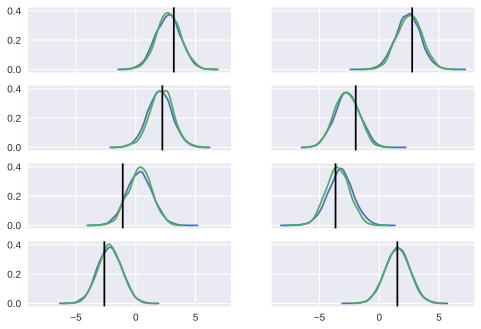

In [39]:
# Plot some datapoints and their prediction distributions
# as computed by MCMC and variational Bayes
fig, axes = plt.subplots(4, 2, sharex='all', sharey='all')
for i in range(4):
  for j in range(2):
    ix = i*2+j
    pred_dist_var = prediction_dist_var[:, ix, 0]
    pred_dist = prediction_distribution[ix,:]
    sns.kdeplot(pred_dist, ax=axes[i][j])
    sns.kdeplot(pred_dist_var, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix,0], color='k')

TODO: compare the coverage of the 95% intervals

In [40]:
# Compute proportion of estimates on validation data 
# which fall within the 95% prediction interval
q0 = 2.5
q1 = 97.5
within_conf_int = np.zeros(N_val)
within_conf_int_var = np.zeros(N_val)
for i in range(N_val):
  # For MCMC
  pred_dist = prediction_distribution[i,:]  
  p0 = np.percentile(pred_dist, q0)
  p1 = np.percentile(pred_dist, q1)
  if p0<=y_val[i] and p1>y_val[i]:
    within_conf_int[i] = 1
    
  # For variational model
  pred_dist_var = prediction_dist_var[:, i, 0]
  p0 = np.percentile(pred_dist_var, q0)
  p1 = np.percentile(pred_dist_var, q1)
  if p0<=y_val[i] and p1>y_val[i]:
    within_conf_int_var[i] = 1
    
# Print 95% interval coverage
print('Percent of validation samples w/i the %0.1f %% confidence interval:' 
      % (q1-q0))
print('MCMC: %0.1f%%' % (100*np.mean(within_conf_int)))
print('Variational: %0.1f%%' % (100*np.mean(within_conf_int_var)))

Percent of validation samples w/i the 95.0 % confidence interval:
MCMC: 94.9%
Variational: 93.0%


talk about why the variational model might be slightly worse (would probs be better if std dev param was variational too instead of point-inferred)

## Conclusion

recap, advantages/disadvantages of each model (time, complexity)

talk about how TFP is such a new project and it's constantly evolving, wouldn't be suprised if much of the stuff in this post is outdated pretty quickly.

what else you can do, e.g. taxi data

Outline this notebook: 

- MCMC linear model
- Variational linear model ("simple neural net")


Next notebook:
- multi-layer neural net (but w/ constant noise term, use on taxi trip dataset and measure coverage of the 95% conf interval)
- 2 module multi-layer neural net (one to predict mean, other to predict variance), show how it can predict when noise increases in a simple heteroscedastic example, then use on taxi trip duration data! and see if it makes the coverage of the 95% conf interval closer to 95%!